# Assignment 1

This code baseline is inspired by and modified from [this great tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).

This code can achieve an accuracy of approximately 86.50% on CIFAR-10. Please set up the environment and run your experiments starting from this baseline. You are expected to achieve an accuracy higher than this baseline.

In [1]:
# import some necessary packages
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.datasets as tv_datasets
import torchvision.transforms as tv_transforms


import matplotlib.pyplot as plt

In [2]:
# 残差结构
class Resblock(nn.Module):
  def __init__(self,in_channel,out_channel,downsample=False):
    super().__init__()
    self.in_channel = in_channel
    self.out_channel = out_channel
    self.downsample = downsample
    strides = 2 if self.downsample else 1
    if self.downsample or in_channel!=out_channel:
      self.conv3 = nn.Conv2d(in_channel,out_channel,kernel_size=1,stride=strides,padding=0,bias=False)

    self.conv1 = nn.Conv2d(in_channel,out_channel,kernel_size=3,stride =strides,padding =1,bias=False)
    self.bn1  = nn.BatchNorm2d(out_channel)
    self.relu1 = nn.ReLU(inplace = True)
    self.bn2  = nn.BatchNorm2d(out_channel)
    self.conv2 = nn.Conv2d(out_channel,out_channel,kernel_size=3,stride=1,padding=1,bias=False)
    self.relu2 = nn.ReLU(inplace = True)

  def forward(self,x):
    identity = x
    Y = self.relu1(self.bn1(self.conv1(x)))
    Y = self.bn2(self.conv2(Y))
    if self.downsample or self.in_channel!=self.out_channel:
      identity = self.conv3(identity)
    Y=Y+identity
    return self.relu2(Y)



In [3]:
# some experimental setup
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_epochs = 128
batch_size = 256
num_workers = 2
print_every = 200

optim_name = "Adam"
optim_kwargs = dict(
    lr=1e-4,
    weight_decay=1e-6,
)

# preprocessing pipeline for input images
transformation = dict()
for data_type in ("train", "test"):
    is_train = data_type=="train"
    
    if is_train:
        transformation[data_type] = tv_transforms.Compose([
            tv_transforms.TrivialAugmentWide(),
            tv_transforms.RandomRotation(degrees=15),
            tv_transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            tv_transforms.RandomHorizontalFlip(),
            
            tv_transforms.ToTensor(),
            tv_transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
            
            tv_transforms.RandomErasing(p=0.25, scale=(0.02, 0.2)),
        ])
    else:
        transformation[data_type] = tv_transforms.Compose([
            tv_transforms.ToTensor(),
            tv_transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ])


In [4]:
from datasets import load_dataset, Image 
from torch.utils.data import Dataset
import os
import torch

class HuggingFaceWrapper(Dataset):
    """一个适配器类，使Hugging Face数据集与torchvision的(img, target)格式兼容"""
    def __init__(self, hf_dataset, transform=None):
        self.hf_dataset = hf_dataset
        self.transform = transform
    
    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        sample = self.hf_dataset[idx]
        

        img = sample['image']
        target = sample['label']
        img = img.convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, target


local_data_dir = "./imagenet/data" 

data_files = {
    "train": os.path.join(local_data_dir, "train-00000-of-00001-1359597a978bc4fa.parquet"),
    "valid": os.path.join(local_data_dir, "valid-00000-of-00001-70d52db3c749a935.parquet")
}

print(f"正在从本地 Parquet 文件 {local_data_dir} 加载 tiny-imagenet...")

hf_datasets = load_dataset(
    "parquet",
    data_files=data_files
)


print("正在转换 'image' 列为 Image 格式...")
hf_datasets = hf_datasets.cast_column("image", Image())
print("转换完成。")


hf_dataset_train = hf_datasets['train']
hf_dataset_val = hf_datasets['valid'] 
print("数据集加载完成。")


dataset, loader = {}, {}

dataset["train"] = HuggingFaceWrapper(hf_dataset_train, transform=transformation['train'])
dataset["test"] = HuggingFaceWrapper(hf_dataset_val, transform=transformation['test'])


for data_type in ("train", "test"):
    is_train = data_type=="train"
    loader[data_type] = torch.utils.data.DataLoader(
        dataset[data_type], batch_size=batch_size, shuffle=is_train, num_workers=num_workers,
    )

print("DataLoader 创建完成。")

正在从本地 Parquet 文件 ./imagenet/data 加载 tiny-imagenet...
正在转换 'image' 列为 Image 格式...
转换完成。
数据集加载完成。
DataLoader 创建完成。


In [ ]:
class MyResNet(nn.Module):
    def __init__(self, base_width=64, num_blocks=[2, 2, 3, 3], num_classes=200):

        super().__init__()
        self.in_channel = base_width 

        c1 = base_width
        self.stem = nn.Sequential(
            nn.Conv2d(3, c1, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(c1),
            nn.ReLU(inplace=True),
            nn.Conv2d(c1, c1, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(c1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) # -> (c1, 16, 16)
        )
        
        c2 = base_width * 2 
        c3 = base_width * 4 
        c4 = base_width * 8 

        self.layer1 = self._make_layer(c2, num_blocks[0], downsample=True)

        self.layer2 = self._make_layer(c3, num_blocks[1], downsample=True)

        self.layer3 = self._make_layer(c4, num_blocks[2], downsample=True)

        self.final_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(c4 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes),
        )

    def _make_layer(self, out_channel, num_blocks, downsample=False):

        layers = []
        layers.append(Resblock(self.in_channel, out_channel, downsample=downsample))

        self.in_channel = out_channel 
        for _ in range(1, num_blocks):
            layers.append(Resblock(self.in_channel, out_channel, downsample=False))
            
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stem(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.final_pool(x)
        x = self.flatten(x) 
        x = self.classifier(x)
        
        return x
net = MyResNet(base_width=128)

In [6]:
# our network architecture
# net = nn.Sequential(
#     nn.Conv2d(3, 128, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.Dropout(0.3),
#     nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.Dropout(0.3),
#     nn.Conv2d(256, 512, 3, padding=1), nn.ReLU(inplace=True),
#     nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),
#     nn.Conv2d(512, 256, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.Dropout(0.3),
#     nn.Flatten(),
#     nn.Linear(256 * 4 * 4, 512), nn.ReLU(inplace=True), nn.Dropout(0.5),
#     nn.Linear(512, 256), nn.ReLU(inplace=True), nn.Dropout(0.5),
#     nn.Linear(256, 128), nn.ReLU(inplace=True), nn.Dropout(0.5),
#     nn.Linear(128, 10),
# )

# move to device
net.to(device)

# print the number of parameters
print(f"number of parameters: {sum(p.numel() for p in net.parameters() if p.requires_grad) / 1_000_000:.2f}M")

number of parameters: 97.47M


## Start Training

[epoch=  1, iter=  200] loss: 5.262
[Epoch   1] Validation loss: 4.787, Accuracy: 3.25%
[epoch=  2, iter=  200] loss: 4.844
[Epoch   2] Validation loss: 4.370, Accuracy: 7.39%
[epoch=  3, iter=  200] loss: 4.506
[Epoch   3] Validation loss: 3.907, Accuracy: 12.55%
[epoch=  4, iter=  200] loss: 4.210
[Epoch   4] Validation loss: 3.627, Accuracy: 18.17%
[epoch=  5, iter=  200] loss: 3.990
[Epoch   5] Validation loss: 3.486, Accuracy: 19.92%
[epoch=  6, iter=  200] loss: 3.794
[Epoch   6] Validation loss: 3.228, Accuracy: 24.16%
[epoch=  7, iter=  200] loss: 3.626
[Epoch   7] Validation loss: 3.095, Accuracy: 26.81%
[epoch=  8, iter=  200] loss: 3.485
[Epoch   8] Validation loss: 2.932, Accuracy: 29.88%
[epoch=  9, iter=  200] loss: 3.351
[Epoch   9] Validation loss: 2.826, Accuracy: 31.70%
[epoch= 10, iter=  200] loss: 3.239
[Epoch  10] Validation loss: 2.663, Accuracy: 35.46%
[epoch= 11, iter=  200] loss: 3.145
[Epoch  11] Validation loss: 2.573, Accuracy: 38.07%
[epoch= 12, iter=  200]

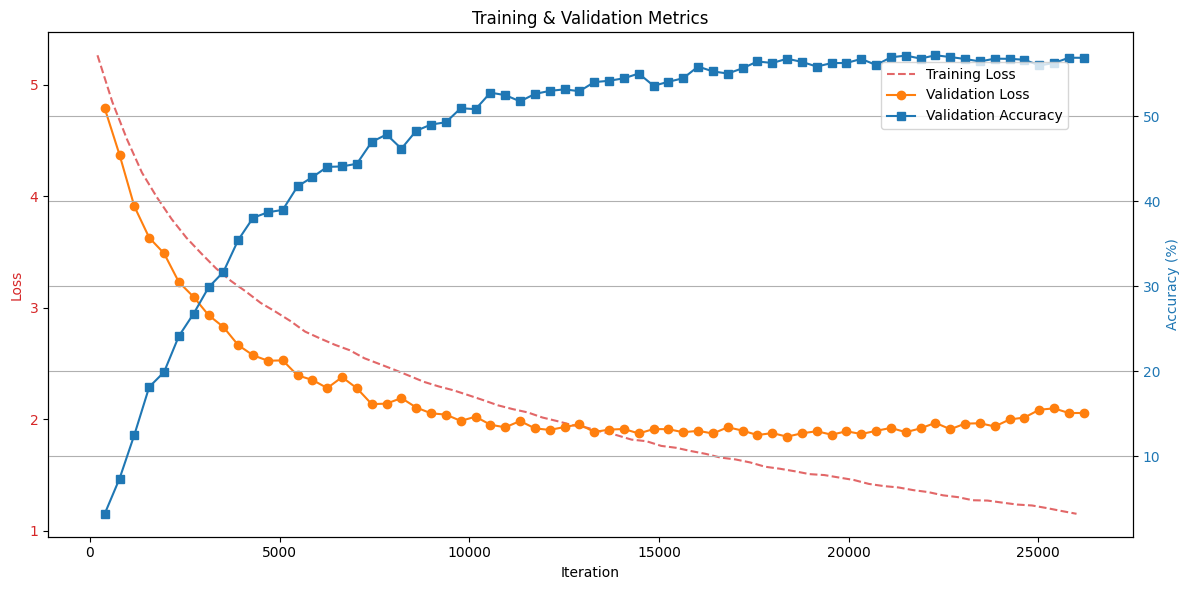

In [7]:
# the network optimizer
optimizer = getattr(optim, optim_name)(net.parameters(), **optim_kwargs)

# loss function
criterion = nn.CrossEntropyLoss()

loss_history = []
iter_history = []
current_iter = 0
val_loss_history = []
val_acc_history = []
val_iter_history = []
patience = 20
epochs_no_improve = 0 
best_val_loss = float('inf')


# training loop
net.train()
for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    for i, (img, target) in enumerate(loader["train"]):
        img, target = img.to(device), target.to(device)


        pred = net(img)
        loss = criterion(pred, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        current_iter += 1
        if i % print_every == print_every - 1:
            avg_loss = running_loss / print_every
            print(f"[epoch={epoch + 1:3d}, iter={i + 1:5d}] loss: {running_loss / print_every:.3f}")
            iter_history.append(current_iter)
            loss_history.append(avg_loss)
            running_loss = 0.0

    net.eval()
    val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for img, target in loader["test"]:
            img, target = img.to(device), target.to(device)
            pred = net(img)
            loss = criterion(pred, target)
            val_loss += loss.item()
            total += len(target)
            correct += (torch.argmax(pred, dim=1) == target).sum().item()

    avg_val_loss = val_loss / len(loader["test"])
    accuracy = 100 * correct / total

    print(f"[Epoch {epoch + 1:3d}] Validation loss: {avg_val_loss:.3f}, Accuracy: {accuracy:.2f}%")
    val_iter_history.append(current_iter)
    val_loss_history.append(avg_val_loss)
    val_acc_history.append(accuracy)
    # 早停
    if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0 
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"\\nEarly stopping triggered after {patience} epochs without improvement.")
        break 


print("Finished Training")
# 画图
fig, ax1 = plt.subplots(figsize=(12, 6))
plt.title('Training & Validation Metrics')

ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss', color='tab:red')
ax1.plot(iter_history, loss_history, color='tab:red', linestyle='--', alpha=0.7, label='Training Loss')
ax1.plot(val_iter_history, val_loss_history, color='tab:orange', marker='o', label='Validation Loss')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy (%)', color='tab:blue')
ax2.plot(val_iter_history, val_acc_history, color='tab:blue', marker='s', label='Validation Accuracy')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))

fig.tight_layout()
plt.grid(True)
plt.savefig('depp_aug.png')

## Evaluating its accuracy

In [8]:
net.eval()
correct, total = 0, 0
with torch.no_grad():
    for img, target in loader["test"]:
        img, target = img.to(device), target.to(device)
        
        # make prediction
        pred = net(img)
        
        # accumulate
        total += len(target)
        correct += (torch.argmax(pred, dim=1) == target).sum().item()

print(f"Accuracy of the network on the {total} test images: {100 * correct / total:.2f}%")

Accuracy of the network on the 10000 test images: 56.89%
